In [1]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Grabbing the nominees
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'BEST PICTURE':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'})
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
                    statement = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    sub_result['film_title'] = film_title
                    sub_result['statement'] = statement
                    sub_result['is_winner'] = 1
                    if sub.find('span',{'class':'glyphicon glyphicon-star'}):
                        sub_result['winner'] = 1
                    else:
                        sub_result['winner'] = 0
                        
                    result[film_title] = sub_result
                    
        except Exception:
            pass
    return result

- to scrap the data from The Official Academy Awards Database and append it to the current data set.
- If you want to know the alignment of the html framework on Oscar website, you can right click on the Chrome webpage, select “Inspect”, then you will enter the Chrome development mode which you can find the position that the information is located.
- The value in “nominee” will be 1 for all movies since the movies retrieved from Oscar website are all nominees.
- The value in "winner" will be 1 for all winners.


In [3]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2018
best_2018 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')


The output should be a json like below 
{'Black Panther': 
  {'film_title': 'Black Panther',
  'statement': 'Kevin Feige, Producer',
  'nominee': 1,
  'winner': 0}}

In [4]:
# Load Data 
#Movies data set contains all movies by years + 2018 nominatted  movies
# credits contains the detailed information of the movies like cast,crew 
#for 2016,2017 and 2018 since there is no data in kaggle we use tmdb api to scrape the movies info
#awards dataset contain all the nominees by category list for the year till 2015, we will append 2016,17 and 2018 next by appending tmdb scarped data
import numpy as np
import pandas as pd
# read from award
df_all_awards = pd.read_csv('database.csv', skiprows = 1, names=['year','ceremony','award','is_winner','winner','movieName','filmInfo'])
df_all_movies = pd.read_csv('movies.csv')
df_all_credits = pd.read_csv('credits.csv')
df2018_all_movies = pd.read_csv('2018_best_picture_tmdb.csv')
df1617_movies = pd.read_csv('2016_2017_best_picture_tmdb.csv')
#df_credits = df_credits.append(df2018_movies)

df_all_awards

,year,ceremony,award,is_winner,winner,movieName,filmInfo
0,1928,1,Actor,NaN,NaN,Richard Barthelmess,The Noose
1,1928,1,Actor,1.0,1.0,Emil Jannings,The Last Command
2,1928,1,Actress,NaN,NaN,Louise Dresser,A Ship Comes In
3,1928,1,Actress,1.0,1.0,Janet Gaynor,7th Heaven
4,1928,1,Actress,NaN,NaN,Gloria Swanson,Sadie Thompson
5,1928,1,Art Direction,NaN,NaN,Rochus Gliese,Sunrise
6,1928,1,Art Direction,1.0,1.0,William Cameron Menzies,The Dove; Tempest
7,1928,1,Art Direction,NaN,NaN,Harry Oliver,7th Heaven
8,1928,1,Cinematography,NaN,NaN,George Barnes,The Devil Dancer; The Magic Flame; Sadie Thompson
9,1928,1,Cinematography,1.0,1.0,Charles Rosher,Sunrise


In [5]:
# append the data we scrapped to the df_allawards
data = []
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Best Picture', v['is_winner'],v['winner'], v['film_title'], v['statement']])
    data.append(row[0])
  
for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Best Picture', v['is_winner'],v['winner'], v['film_title'], v['statement']])
    data.append(row[0])

for k,v in best_2018.items():
   row = []
   row.append(['2018', 91, 'Best Picture', v['is_winner'],v['winner'], v['film_title'], v['statement']])
   data.append(row[0])


In [6]:
# pass the column name to the columns!!! Or there will be a runtime error
data
df_all_awards=df_all_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','is_winner','winner','movieName','filmInfo']),ignore_index=True)
#df_all_awards = pd.concat([df_all_awards,data])

df_all_awards['year']= df_all_awards['year'].astype(int)
#df_all_awards['winner']= df_all_awards['winner'].astype(int)
df_all_awards.drop_duplicates(subset=['movieName','year','winner','award'], inplace=True, keep='last')
df_all_awards.head()
#df_all_awards[df_all_awards['movieName']=='Tom Jones ']
#print(data)

,year,ceremony,award,is_winner,winner,movieName,filmInfo
0,1928,1,Actor,NaN,NaN,Richard Barthelmess,The Noose
1,1928,1,Actor,1.0,1.0,Emil Jannings,The Last Command
2,1928,1,Actress,NaN,NaN,Louise Dresser,A Ship Comes In
3,1928,1,Actress,1.0,1.0,Janet Gaynor,7th Heaven
4,1928,1,Actress,NaN,NaN,Gloria Swanson,Sadie Thompson


In [7]:
# Data Manipulation - Joining the dataframes
# We start by saving only the movies we have credits info for and merge on the same movie id

if 'title' in df_all_credits.columns: 
    df_all_credits = df_all_credits.drop('title',axis=1) 
    
df_all_credits_movies = df_all_credits.set_index('movie_id').join(df_all_movies.set_index('id'))
#df_all_credits_movies

In [8]:
#Convert released date to date format so we can use it later for our max, min date
df2018_all_movies['release_date'] = pd.to_datetime(df2018_all_movies['release_date'], format='%Y-%m-%d')


In [9]:
#Convert released date to date format so we can use it later for our max, min date
df1617_movies['release_date'] = pd.to_datetime(df1617_movies['release_date'], format='%Y-%m-%d')

In [10]:
#we will append our 2016,2017 and 2018 scarped tmdb info on credits like crew,cast to the credits file
df_all_credits_movies = df_all_credits_movies.append(df2018_all_movies)
df_all_credits_movies = df_all_credits_movies.append(df1617_movies)

In [11]:
df_all_credits_movies['release_date'] = pd.to_datetime(df_all_credits_movies['release_date'], format='%Y-%m-%d')


In [12]:
#get the earliest release date from the dataset
min_year = min(df_all_credits_movies['release_date']) #1916-09-04
max_year = max(df_all_credits_movies['release_date']) #2017-02-03
print(min_year)
print(max_year)

1916-09-04 00:00:00
2018-12-25 00:00:00


In [13]:
df_all_credits_movies['released_year'] = df_all_credits_movies['release_date'].dt.year.fillna(0.0).astype(int)
df_all_credits_movies
df_all_awards[df_all_awards['movieName']=='Tom Jones ']

,year,ceremony,award,is_winner,winner,movieName,filmInfo
3986,1963,36,Art Direction (Color),NaN,NaN,Tom Jones,"Art Direction: Ralph Brinton, Ted Marshall, Jo..."
4011,1963,36,Directing,1.0,1.0,Tom Jones,Tony Richardson
4035,1963,36,"Music (Music Score, Substantially Original)",1.0,1.0,Tom Jones,John Addison
4050,1963,36,Best Picture,1.0,1.0,Tom Jones,"Tony Richardson, Producer"
4074,1963,36,"Writing (Screenplay, Based on Material from An...",1.0,1.0,Tom Jones,John Osborne


In [14]:
df_all_credits_movies.to_csv('df_credits_pictures_test.csv', index=False)

In [15]:
# Select movies that are only in Outstanding Picture or Best Picture awards category and create a new df, df_picture_awards
df_all_picture_awards = df_all_awards.loc[df_all_awards['award'].isin(['Outstanding Picture','Best Picture'])]
df_all_picture_awards.reset_index(drop = True, inplace = True)
#332 Rows
#df_all_picture_awards[df_all_picture_awards['movieName']=='My Fair Lady ']
#df_all_credits_movies = df_all_credits_movies.drop(['year2'], axis=1)
# Get only movies that hae been released
df_all_credits_movies = df_all_credits_movies.loc[df_all_credits_movies['status'].isin(['Released'])]
df_all_credits_movies
df_all_picture_awards[df_all_picture_awards['year']=='2016']
print("--------------")
print(df_all_picture_awards.columns)
print("--------------")
print(df_all_credits_movies.columns)



--------------
Index(['year', 'ceremony', 'award', 'is_winner', 'winner', 'movieName',
       'filmInfo'],
      dtype='object')
--------------
Index(['budget', 'cast', 'crew', 'genres', 'homepage', 'keywords', 'movie_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'released_year'],
      dtype='object')


In [16]:
# Replace all the null value in ‘nominee’ column with 1
# df_picture_awards['winner'].isnull().sum()
df_all_picture_awards['is_winner'].fillna(0,inplace = True)
#df_all_picture_awards[df_all_picture_awards['winner']==0]

In [17]:
# join df_all_credits_movies and df_all_picture_awards by movie name

# Change the title in the movie to lower case
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_all_picture_awards['movieName'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_all_credits_movies['title'].str.lower().str.strip().values]

df_all_picture_awards.loc[:,'movie_title'] = movieName 
df_all_credits_movies.loc[:,'movie_title'] = title

# check the dataframe, we can see the string in movie_title now is valid
#df_all_picture_awards.movie_title

In [18]:
# join the two tables, merge the data
df = df_all_picture_awards.merge(df_all_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)
df
#df[df['nominee']==1]

,year,ceremony,award,is_winner,winner,movieName,filmInfo,movie_title,budget,cast,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,released_year
0,1962.0,35.0,Best Picture,1.0,1.0,Lawrence of Arabia,"Sam Spiegel, Producer",lawrence of arabia,15000000,"[{""cast_id"": 18, ""character"": ""T.E. Lawrence"",...",...,1962-12-10,69995385,216.0,"[{""iso_639_1"": ""ar"", ""name"": ""\u0627\u0644\u06...",Released,NaN,Lawrence of Arabia,7.8,851,1962
1,1962.0,35.0,Best Picture,0.0,NaN,The Longest Day,"Darryl F. Zanuck, Producer",the longest day,10000000,"[{""cast_id"": 20, ""character"": ""Col. Thompson"",...",...,1962-09-25,50100000,178.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,This is the day that changed the world... When...,The Longest Day,7.2,234,1962
2,1962.0,35.0,Best Picture,0.0,NaN,To Kill a Mockingbird,"Alan J. Pakula, Producer",to kill a mockingbird,2000000,"[{""cast_id"": 8, ""character"": ""Atticus Finch"", ...",...,1962-12-25,13129846,129.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,To Kill a Mockingbird,8.0,657,1962
3,1963.0,36.0,Best Picture,0.0,NaN,Cleopatra,"Walter Wanger, Producer",cleopatra,31115000,"[{""cast_id"": 2, ""character"": ""Cleopatra"", ""cre...",...,1963-06-12,71000000,248.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The motion picture the world has been waiting ...,Cleopatra,6.7,146,1963
4,1963.0,36.0,Best Picture,1.0,1.0,Tom Jones,"Tony Richardson, Producer",tom jones,1000000,"[{""cast_id"": 6, ""character"": ""Tom Jones"", ""cre...",...,1963-10-06,37600000,128.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Tom Jones! . . . loves and loves and loves and...,Tom Jones,6.1,39,1963
5,1964.0,37.0,Best Picture,0.0,NaN,Dr. Strangelove or: How I Learned to Stop Worr...,"Stanley Kubrick, Producer",dr strangelove or how i learned to stop worryi...,1800000,"[{""cast_id"": 13, ""character"": ""Group Capt. Lio...",...,1964-01-29,9440272,95.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The hot-line suspense comedy,Dr. Strangelove or: How I Learned to Stop Worr...,8.0,1442,1964
6,1964.0,37.0,Best Picture,0.0,NaN,Mary Poppins,"Walt Disney and Bill Walsh, Producers",mary poppins,6000000,"[{""cast_id"": 1, ""character"": ""Mary Poppins"", ""...",...,1964-08-27,102272727,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,It's supercalifragilisticexpialidocious!,Mary Poppins,7.4,1183,1964
7,1964.0,37.0,Best Picture,1.0,1.0,My Fair Lady,"Jack L. Warner, Producer",my fair lady,17000000,"[{""cast_id"": 1, ""character"": ""Eliza Doolittle""...",...,1964-10-21,72070731,170.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The loverliest motion picture of them all!,My Fair Lady,7.4,352,1964
8,1965.0,38.0,Best Picture,0.0,NaN,Doctor Zhivago,"Carlo Ponti, Producer",doctor zhivago,11000000,"[{""cast_id"": 18, ""character"": ""Dr. Yuri Zhivag...",...,1965-12-22,111858363,197.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Turbulent were the times and fiery was the lov...,Doctor Zhivago,7.4,247,1965
9,1965.0,38.0,Best Picture,1.0,1.0,The Sound of Music,"Robert Wise, Producer",the sound of music,8200000,"[{""cast_id"": 1, ""character"": ""Maria"", ""credit_...",...,1965-03-02,286214286,174.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The happiest sound in all the world!,The Sound of Music,7.4,941,1965


In [19]:
#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
df.drop('movieName',axis = 1, inplace = True)
df.drop('filmInfo',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['winner'].fillna(0,inplace=True) #fill NA with 0

# Print master df to csv
# 4795 rows of movies with appended Best Picture data, that we had crew info for
df.to_csv('masterList_final.csv', index=False)


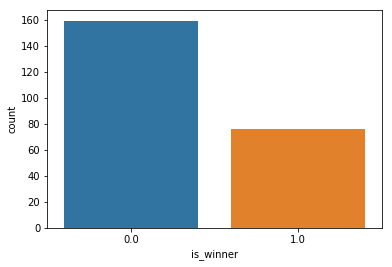

In [20]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='is_winner', data = df)


In [21]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['is_winner'] == 0])) #4586
print(len(df.loc[df['is_winner'] == 1])) #209

159
76


In [54]:

#balance the data
df_subset_0 = df.loc[df['is_winner'] == 0]
df_subset_1 = df.loc[df['is_winner'] == 1]
#df_subset_1['winner']
df_subset_0.drop('is_winner',axis=1,inplace=True)
df_subset_1.drop('is_winner',axis=1,inplace=True)

# #sample with replacement
#df_subset_0 = df_subset_0.sample(150) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
#df_subset[df_subset['year2']== 2017.0]
df_new = df_subset.merge(df_all_picture_awards, left_on = 'movie_title', right_on = 'movie_title', how = 'left')
df_new = df_new.fillna(0)
df_new
#df_new[df_new['year2']== 2017.0]

,winner_x,movie_title,budget,cast,crew,genres,keywords,movie_id,original_language,original_title,...,vote_average,vote_count,released_year,year,ceremony,award,is_winner,winner_y,movieName,filmInfo
0,0.0,the longest day,10000000,"[{""cast_id"": 20, ""character"": ""Col. Thompson"",...","[{""credit_id"": ""53ba7918c3a3685eb1006f7a"", ""de...","[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...","[{""id"": 1956, ""name"": ""world war ii""}, {""id"": ...",0.0,en,The Longest Day,...,7.2,234,1962,1962,35,Best Picture,0.0,0.0,The Longest Day,"Darryl F. Zanuck, Producer"
1,0.0,to kill a mockingbird,2000000,"[{""cast_id"": 8, ""character"": ""Atticus Finch"", ...","[{""credit_id"": ""52fe4259c3a36847f8017773"", ""de...","[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...","[{""id"": 577, ""name"": ""black people""}, {""id"": 8...",0.0,en,To Kill a Mockingbird,...,8.0,657,1962,1962,35,Best Picture,0.0,0.0,To Kill a Mockingbird,"Alan J. Pakula, Producer"
2,0.0,cleopatra,31115000,"[{""cast_id"": 2, ""character"": ""Cleopatra"", ""cre...","[{""credit_id"": ""54afb978c3a3683fba003e96"", ""de...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 36, ""name...","[{""id"": 5049, ""name"": ""ancient rome""}, {""id"": ...",0.0,en,Cleopatra,...,6.7,146,1963,1963,36,Best Picture,0.0,0.0,Cleopatra,"Walter Wanger, Producer"
3,0.0,dr strangelove or how i learned to stop worryi...,1800000,"[{""cast_id"": 13, ""character"": ""Group Capt. Lio...","[{""credit_id"": ""52fe4290c3a36847f802879d"", ""de...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 840, ""name"": ""usa president""}, {""id"": ...",0.0,en,Dr. Strangelove or: How I Learned to Stop Worr...,...,8.0,1442,1964,1964,37,Best Picture,0.0,0.0,Dr. Strangelove or: How I Learned to Stop Worr...,"Stanley Kubrick, Producer"
4,0.0,mary poppins,6000000,"[{""cast_id"": 1, ""character"": ""Mary Poppins"", ""...","[{""credit_id"": ""52fe4243c3a36847f8010859"", ""de...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""...","[{""id"": 212, ""name"": ""london england""}, {""id"":...",0.0,en,Mary Poppins,...,7.4,1183,1964,1964,37,Best Picture,0.0,0.0,Mary Poppins,"Walt Disney and Bill Walsh, Producers"
5,0.0,doctor zhivago,11000000,"[{""cast_id"": 18, ""character"": ""Dr. Yuri Zhivag...","[{""credit_id"": ""52fe428bc3a36847f8026fa1"", ""de...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""id"": 128, ""name"": ""love triangle""}, {""id"": ...",0.0,en,Doctor Zhivago,...,7.4,247,1965,1965,38,Best Picture,0.0,0.0,Doctor Zhivago,"Carlo Ponti, Producer"
6,0.0,alfie,60000000,"[{""cast_id"": 1, ""character"": ""Alfie"", ""credit_...","[{""credit_id"": ""562643e89251413ded006a07"", ""de...","[{""id"": 35, ""name"": ""Comedy""}]","[{""id"": 242, ""name"": ""new york""}, {""id"": 1332,...",0.0,en,Alfie,...,5.6,248,2004,1966,39,Best Picture,0.0,0.0,Alfie,"Lewis Gilbert, Producer"
7,0.0,doctor dolittle,71000000,"[{""cast_id"": 1, ""character"": ""Dr. John Dolittl...","[{""credit_id"": ""52fe4380c3a36847f8058d3d"", ""de...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""...","[{""id"": 167625, ""name"": ""talking to animals""},...",0.0,en,Doctor Dolittle,...,5.4,686,1998,1967,40,Best Picture,0.0,0.0,Doctor Dolittle,"Arthur P. Jacobs, Producer"
8,0.0,butch cassidy and the sundance kid,6000000,"[{""cast_id"": 17, ""character"": ""Butch Cassidy"",...","[{""credit_id"": ""52fe4263c3a36847f801a813"", ""de...","[{""id"": 36, ""name"": ""History""}, {""id"": 18, ""na...","[{""id"": 1016, ""name"": ""wyoming""}, {""id"": 6165,...",0.0,en,Butch Cassidy and the Sundance Kid,...,7.4,650,1969,1969,42,Best Picture,0.0,0.0,Butch Cassidy and the Sundance Kid,"John Foreman, Producer"
9,0.0,fiddler on the roof,9000000,"[{""cast_id"": 6, ""character"": ""Tevye"", ""credit_...","[{""credit_id"": ""593a693cc3a368235b00a599"", ""de...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""id"": 941, ""name"": ""tradition""}, {""id"": 1566...",0.0,en,Fiddler on t

In [55]:
print(len(df_new))

235


In [56]:
#check number of null values in the dataset
df_new = df_new.drop(['winner_y'], axis=1)

In [57]:
df_new = df_new.rename(columns={"winner_x": "winner"})
df_new.isnull().sum()

winner                  0
movie_title             0
budget                  0
cast                    0
crew                    0
genres                  0
keywords                0
movie_id                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
released_year           0
year                    0
ceremony                0
award                   0
is_winner               0
movieName               0
filmInfo                0
dtype: int64

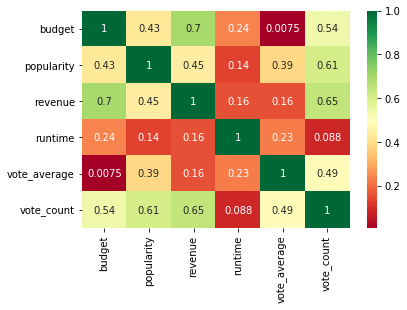

In [58]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','runtime','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)

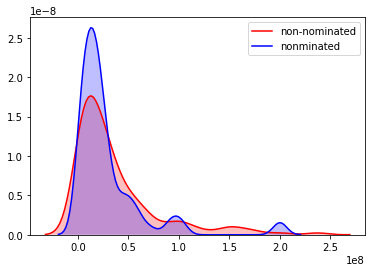

In [59]:
# Density Curve
# budget
budget0 = df_new[df_new['is_winner'] == 0]['budget']
budget1 = df_new[df_new['is_winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

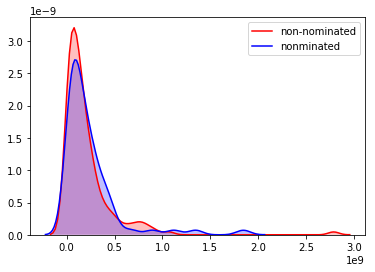

In [60]:
# revenue
# density curve
revenue0 = df_new[df_new['is_winner'] == 0]['revenue']
revenue1 = df_new[df_new['is_winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

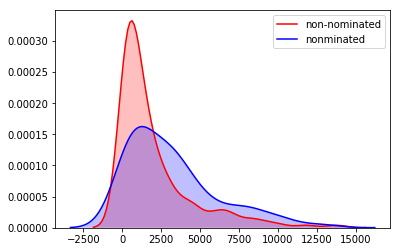

In [61]:
# vote count
vc0 = df_new[df_new['is_winner'] == 0]['vote_count']
vc1 = df_new[df_new['is_winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

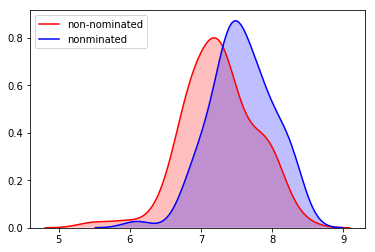

In [62]:
# vote average
va0 = df_new[df_new['is_winner'] == 0]['vote_average']
va1 = df_new[df_new['is_winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

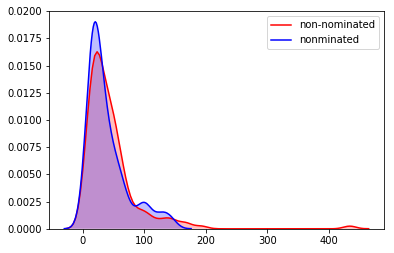

In [63]:
#popularity
popularity0 = df_new[df_new['is_winner'] == 0]['popularity']
popularity1 = df_new[df_new['is_winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

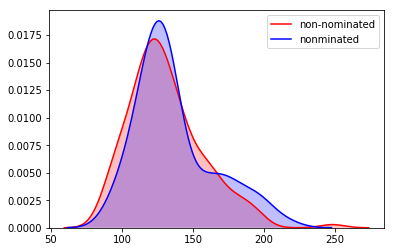

In [64]:
#runtime
runtime0 = df_new[df_new['is_winner'] == 0]['runtime']
runtime1 = df_new[df_new['is_winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

In [65]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = eval(df_new.loc[i,'genres'])
    for it in genres:
        #print(it)
        genres_set.add(it['name'])
        if df_new.loc[i,'is_winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'is_winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [66]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
print(df_genres.head())

        War  Science Fiction    Comedy   Fantasy    Horror   Romance  \
0  0.037433         0.024064  0.066845  0.034759  0.005348  0.098930   
1  0.054645         0.010929  0.065574  0.016393  0.005464  0.087432   

   Thriller  Adventure   Mystery     Music     Crime    Family  Animation  \
0  0.082888   0.058824  0.026738  0.013369  0.050802  0.018717   0.005348   
1  0.054645   0.032787  0.010929  0.038251  0.060109  0.016393   0.000000   

    History     Drama    Action   Western  
0  0.058824  0.363636  0.042781  0.010695  
1  0.109290  0.377049  0.043716  0.016393  


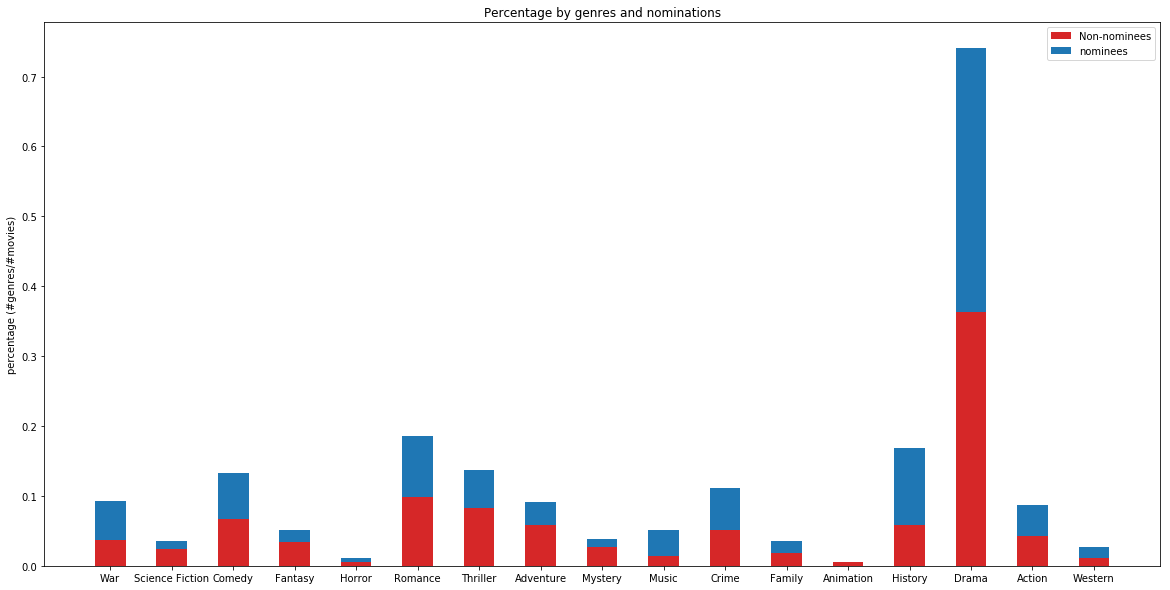

In [67]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.5

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])

plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

In [68]:
# Feature Engineering
# Since many columns such as “crew”, “cast” contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
# We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
# To look at the structure of column (eg.”cast”), we can use: df.loc[0,’cast’]
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}
    fails = []

    for item in df[column_name]:
        group = eval(item)
        #print(type(group))
        for it in group:
            #print (it)
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        #print(item)
        group = eval(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output

In [69]:
df2 = feature_engineering("cast", df_new, "name")
#df2['cast']
df2 = df2.drop(columns=['cast'])

In [70]:
# director
crew_name = {}

for item in df2['crew']:
    crew = eval(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] not in crew_name:
                crew_name[it['name']] = 1
            else:
                crew_name[it['name']]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in crew_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['crew']:
    crew = eval(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] in final_crew:
                index = final_crew[it['name']]
                np_crew[row][index] = 1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)

In [71]:
df3=df3.drop(['crew'],axis=1)
# #genres
df4 = feature_engineering("genres", df3, "name")
#df4
df4 = df4.drop(['genres'], axis = 1)
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)
# drop the columns not used
df_clean = df8.drop(["movie_title","original_title","overview","tagline",'title','original_language','status','release_date','movieName','filmInfo','award'],axis=1)


In [72]:
df_clean.drop_duplicates()
df_clean

,winner,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,released_year,year,...,yi,cs,ja,fa,ga,xh,tr,sw,hu,ko
0,0.0,10000000,0.0,19.524972,50100000,178.0,7.2,234,1962,1962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2000000,0.0,22.139842,13129846,129.0,8.0,657,1962,1962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,31115000,0.0,13.244365,71000000,248.0,6.7,146,1963,1963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1800000,0.0,41.996783,9440272,95.0,8.0,1442,1964,1964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,6000000,0.0,59.961523,102272727,139.0,7.4,1183,1964,1964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,11000000,0.0,12.854853,111858363,197.0,7.4,247,1965,1965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,60000000,0.0,15.219263,13395939,103.0,5.6,248,2004,1966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,71000000,0.0,21.462935,294456605,85.0,5.4,686,1998,1967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,6000000,0.0,24.499996,102308889,110.0,7.4,650,1969,1969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,9000000,0.0,7.623979,83304330,181.0,7.4,134,1971,1971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df_2017  = df_clean.loc[df_clean['released_year'] != 2018]
df_2018  = df_clean.loc[df_clean['released_year'] == 2018]
#df_2018 = df_2018.drop_duplicates(['movie_id'])
df_2018.head()

,winner,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,released_year,year,...,yi,cs,ja,fa,ga,xh,tr,sw,hu,ko
227,0.0,200000000,284054.0,44.448,1346739107,134.0,7.4,12853,2018,2018,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
228,0.0,15000000,487558.0,23.198,48686605,135.0,7.6,3380,2018,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,0.0,52000000,424694.0,38.226,894027543,135.0,8.1,8175,2018,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230,0.0,15000000,375262.0,18.011,82124805,120.0,7.6,2305,2018,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,1.0,23000000,490132.0,25.057,319700000,130.0,8.3,3894,2018,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# Model Training
# split
X_train = df_2017[df_2017.columns.difference(['winner'])]
y_train = df_2017['winner']
X_test_2018 = df_2018[df_2018.columns.difference(['winner'])]
y_test_2018 = df_2018['winner']
print(X_train)


     18th century  1930s  1940s  1950s  1960s  1970s  1980s  19th century  \
0             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
3             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
6             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
7             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
8             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
9             0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
10            0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   
11            0.0    0.0    0.0    0.0    0.0    0.0    0.0           0.0   

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_train_scaled
X_test_scaled = scaler.transform(X_test_2018)
X_test_scaled

array([[-0.06651901, -0.11572751, -0.13392991, ..., -0.0942809 ,
        -0.0942809 , -0.19112739],
       [-0.06651901, -0.11572751, -0.13392991, ..., -0.0942809 ,
        -0.0942809 , -0.19112739],
       [-0.06651901, -0.11572751, -0.13392991, ..., -0.0942809 ,
        -0.0942809 , -0.19112739],
       ...,
       [-0.06651901, -0.11572751, -0.13392991, ..., -0.0942809 ,
        -0.0942809 , -0.19112739],
       [-0.06651901, -0.11572751, -0.13392991, ..., -0.0942809 ,
        -0.0942809 , -0.19112739],
       [-0.06651901, -0.11572751, -0.13392991, ..., -0.0942809 ,
        -0.0942809 , -0.19112739]])

In the following code, we choose 0.81 as the parameters in PCA(), which means 0.81 variance in the features will be retained.

In [86]:
from sklearn.decomposition import PCA
pca = PCA(0.81)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_train_pca
X_test_pca

array([[ 2.69653699, -1.45143866, -0.53953446, ...,  1.89043524,
         0.67480451,  0.46379536],
       [-1.00938021, -1.28741612,  1.24347133, ..., -0.35347661,
         0.42504536, -0.13632625],
       [-0.6774135 , -1.61663555, -1.20646829, ..., -0.67160386,
         0.56003063,  2.1803688 ],
       ...,
       [-0.67140366, -0.86261459,  0.1559784 , ...,  1.02559705,
         0.92576595, -0.79115617],
       [-0.6706521 , -0.88395743, -0.63137003, ..., -0.49231904,
        -1.27060279,  0.41962617],
       [-1.29764478, -1.99014613, -1.73450144, ..., -0.86729327,
         1.08109697, -1.83618626]])

In [87]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [88]:
logisticRegr.score(X_train_pca, y_train)

1.0

In [89]:
# Predict for One Observation

predicted = logisticRegr.predict(X_test_pca)
df_2018['prediction'] = predicted
print(logisticRegr.predict(X_test_pca))


[1. 0. 0. 0. 1. 0. 0. 0.]


In [90]:
logisticRegr.score(X_test_pca, y_test_2018)
# print(predicted)

0.875

In [91]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_2018, predicted).ravel()
sensitivity = tp/(tp+fn)
print("True Positives:",tp)
print("False Positives:",fp)
print("True Negatives:",tn)
print("False Negatives:",fn)
print(sensitivity) # 0.84375

True Positives: 1
False Positives: 1
True Negatives: 6
False Negatives: 0
1.0


In [92]:
print(len(predicted))

8


In [93]:
df_p2018 = df_2018[['movie_id','winner','prediction']]
#df_p2018

In [94]:
df_prediction = df_p2018.merge(df3, on='movie_id', how='left')
df_prediction  = df_prediction.rename(columns={"winner_x": "winner"})
df_prediction[['movie_title','winner','prediction']]

,movie_title,winner,prediction
0,black panther,0.0,1.0
1,blackkklansman,0.0,0.0
2,bohemian rhapsody,0.0,0.0
3,the favourite,0.0,0.0
4,green book,1.0,1.0
5,roma,0.0,0.0
6,a star is born,0.0,0.0
7,vice,0.0,0.0


In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2018, predicted))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92         7
         1.0       0.50      1.00      0.67         1

   micro avg       0.88      0.88      0.88         8
   macro avg       0.75      0.93      0.79         8
weighted avg       0.94      0.88      0.89         8

